# BBC News Classification
In this assignment, we will use data from https://www.kaggle.com/c/learn-ai-bbc/overview, which is a Kaggle competition is about categorizing news articles. You will use matrix factorization to predict the category, submit your results to Kaggle for test evaluation.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.decomposition import NMF
import os
from itertools import permutations

In [2]:
# Loading train data
articles = pd.read_csv("data/bbc/train.csv")

In [3]:
# Displaying what the data looks like
# It has article id, article texts, and category. Here, category is the laabel.
articles

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


In [4]:
# Let's print out a sample article text. You'll also see special characters.
articles['Text'].iloc[0]

'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebb

In [5]:
# There are 5 unique categories (labels)
articles['Category'].unique()

array(['business', 'tech', 'politics', 'sport', 'entertainment'],
      dtype=object)

(array([336.,   0., 261.,   0.,   0., 274.,   0., 346.,   0., 273.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

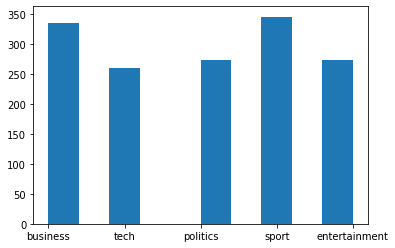

In [6]:
# Let's see how many articles are in each category. It shows that the categories are reasonably balanced.
plt.hist(articles['Category'])

get_feature_names_out## Q1. Text preprocessing
As we have done simple EDA, now, let's extract some feaures from the text.
Read sklearn document for [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) and [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer). Search online about text preprocessing methods based on word count and TF-IDF. 
### [10 pts] Summarize/explain what those methods are. Why is TF-IDF better than simple word count?
(optional: Search and explain other text preprocessing methods such as GloVe or Word2Vec. you can include python snippets on how to use them). 

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from pandas import DataFrame


def create_document_term_matrix(message_list, vectorizer):
    doc_term_matrix = vectorizer.fit_transform(message_list)
    return DataFrame(doc_term_matrix.toarray(), 
                     columns=vectorizer.get_feature_names_out())

### Word Count 

is a NLP algorithm for determining the importance of words used in a document. The algorithm works by taking in a document, in this example two sentences, and tokenizes each unique word in the sentence of the document. Then you create a frequency matrix based on the count of each word comes up in every sentence. You can then use this matrix as training and testing data for classification algorithms. The downside to this type of algorithm is that it does not take into account words that are insignificant to the sentences, like "is" or "to". So this can make the algorithm give more importance to "filler" words in sentences. 

document = ['My name is Tyler', 'Tyler is taking intro to machine Learning']

token_words = ['My', 'name', 'is', 'Tyler', 'taking', 'intro', 'to', 'machine' 'learning']


In [8]:
#Word count code example
document_1 = ['My name is Tyler', 'Tyler is taking intro to machine Learning']
count_vect = CountVectorizer()
create_document_term_matrix(document_1, count_vect)

,intro,is,learning,machine,my,name,taking,to,tyler
0,0,1,0,0,1,1,0,0,1
1,1,1,1,1,0,0,1,1,1


### TF-IDF

TF - Term Frequency, is a way to represent how often a word occurs in a document. If there are several occurance of a word in the document, we expect the TF to rise. To find the TF, you take the number of occurances of a word and divide that by the total number of words in the document. 

$$
t f_{i, j}=\frac{n_{i, j}}{\sum_{k} n_{i, j}}
$$

example: 

      Tyler occurs 2 times in the document and there are 11 total words in the document. so the TF for tyler would be 2/11 = .1818.
        
IDF - Inverse Data Frequency, is another way to represent how common a word is accross all documents. If a word is used in many documents, then the TF-IDF value would decrease. 

$$
i d f(w)=\log \left(\frac{N}{d f_{t}}\right)
$$
      
The idf of a word is calculated by taking the log((# of occurances of a word in all documents) / total # of documents))
      

In [9]:
# example for TF-IDF
document_1 = ['My name is Tyler', 'Tyler is taking intro to machine Learning']
tfidf_vect = TfidfVectorizer()
create_document_term_matrix(document_1, tfidf_vect)

,intro,is,learning,machine,my,name,taking,to,tyler
0,0.000000,0.409937,0.000000,0.000000,0.576152,0.576152,0.000000,0.000000,0.409937
1,0.407824,0.290170,0.407824,0.407824,0.000000,0.000000,0.407824,0.407824,0.290170


### Why is TF-IDF better than word count?

    - TF-IDF does a better job taking into account the less relavent words like it, the , by. TF-IDF makes rare words more prominent and effectively ignores common words. Unlike word count, TF-IDF creates a normalized count where each word count is divided by the number of documents the word appears in. 

In the below example, we will show how to use feature extraction vectorizer. We will show CountVectorizer, but the usage of TfidfVectorizer is also similar. The vectorizer has many options, but `max_features` is most often used. A collection of all words in the all articles is called vocabulary. Since the vocabulary can include so many words, often we want to limit the number of vocabularies in our feature vector. `max_features` is a parameter that sets the limit.

In [10]:
#There are 1490 articles in the train data
data_samples = articles['Text']
# print(len(data_samples))
data_samples

0       worldcom ex-boss launches defence lawyers defe...
1       german business confidence slides german busin...
2       bbc poll indicates economic gloom citizens in ...
3       lifestyle  governs mobile choice  faster  bett...
4       enron bosses in $168m payout eighteen former e...
                              ...                        
1485    double eviction from big brother model caprice...
1486    dj double act revamp chart show dj duo jk and ...
1487    weak dollar hits reuters revenues at media gro...
1488    apple ipod family expands market apple has exp...
1489    santy worm makes unwelcome visit thousands of ...
Name: Text, Length: 1490, dtype: object

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [12]:
# Let's take an example of CountVectorizer
n_features = 200 # For example, we decided to include only 200 words in our vocabulary (but often it needs bigger number) 
count_vectorizer = CountVectorizer(max_features=n_features, stop_words="english")

In [13]:
# .fit_transform() transforms the text data to feature vectors. 
# Here, the feature matrix from CountVectorizer is a word count vector
wordcount = count_vectorizer.fit_transform(data_samples)

In [14]:
# This feature matrix has a shape of (# of articles, # max features)
# The matrix is a sparse matrix format for computation efficiency.
print(wordcount.shape)
# print(wordcount)

(1490, 200)


In [15]:
# Although you can convert a sparse matrix to dense matrix to see the content, 
# usually we don't want to load a dense matrix of very big matrix (such as a matrix with multiple thousands or millions of rows and cols).
# Here, just to show what's inside:
wordcount.todense()
# It shows a word count fewature matrix. 

matrix([[0, 0, 0, ..., 0, 0, 1],
        [0, 1, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 9, 0, 1],
        ...,
        [0, 1, 1, ..., 0, 7, 0],
        [0, 2, 1, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0]])

In [16]:
#For example, the feature vector for the last third article is this:
wordcount.todense()[-3]
# It has 0 count the first vocabulary, 1 count for the second vocabulary, 1 count for the third vocabulary, etc.

matrix([[0, 1, 1, 0, 2, 3, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 0,
         0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 5, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0]])

In [17]:
# .vocabulary_ shows word count for each word in the selected vocabulary in the data
count_vectorizer.vocabulary_

{'chief': 29,
 'called': 26,
 'company': 34,
 'firm': 65,
 'mr': 122,
 'business': 25,
 'told': 179,
 'new': 128,
 'early': 50,
 'said': 155,
 'given': 73,
 'used': 185,
 'did': 46,
 'star': 170,
 'financial': 64,
 'hit': 85,
 'years': 199,
 '2004': 5,
 'week': 192,
 'deal': 43,
 'europe': 57,
 'economy': 52,
 'based': 15,
 'research': 152,
 'january': 94,
 'months': 121,
 'economic': 51,
 'bank': 14,
 'labour': 97,
 'minister': 117,
 'despite': 45,
 'high': 84,
 'expected': 59,
 'year': 198,
 '2003': 4,
 'growth': 80,
 'president': 144,
 'going': 74,
 'half': 81,
 'record': 150,
 'making': 110,
 '10': 1,
 'firms': 66,
 'including': 88,
 'figures': 61,
 'rise': 154,
 'european': 58,
 'bbc': 16,
 'nations': 125,
 'world': 197,
 'service': 164,
 'national': 124,
 'countries': 36,
 'future': 69,
 '000': 0,
 'people': 138,
 'country': 37,
 'international': 91,
 'just': 95,
 'director': 48,
 'saying': 158,
 'place': 140,
 'far': 60,
 'says': 159,
 'china': 30,
 'seen': 163,
 'government': 7

## Q2. Topic Modeling using NMF
Below are the starter codes. We will build TopicModeling class which predicts article labels using NMF algorithm.
You'll need to complete `factorize` and `predict` methods.

### Q2.a Complete factorize function [15 pts]
5 pts each for each STEP. You can do the similar from the example above.    
**Note:** `self.X` is the train and test data combined. In the STEP2 in `factorize` function, we fit all the data so that the feature matrix contains vocabularies from both trin and test data. You could fit with only texts from train data, but then there might be some vocabularies from test data that don't exist in train data. Since we're not showing the labels to the model, using the vectorizer feature extraction with combined data is ok.

### Q2.b Complete STEP4 in predict function [10 pts]
self.features is a feature matrix from the tf-idf vectorizer.
You can retrieve the fitted feature matrix from train data portion by `self.features[:self.n_tr]`
You can calculate `yp_tr` using this train part of the feature matrix. Use the matrix factorization formula (theory) for prediction. It involves some dot products and transpose of matrices. numpy operations require matrices to be numpy array format, which is why we reformatted `tfidf` to `self.features` using `numpy.array` at the end of the `factorize` function.

### Q2.c Complete STEP 5 in predict function [15 pts]
Map the numeric label values 0,1,2,3,4 from the prediction to category strings. Save the test prediction labels to `self.test['Category']`. For example, `self.test['Category']` may look like:    

|     |              |
|:----|:------------|     
|0    |         sport|    
|1    |           tech|     
|2    |          sport|    
|3    |       business|    
|4    |          sport|
|...|          |
|730  |       business|
|731  |  entertainment|
|732  |           tech|
|733  |       business|
|734  |       politics|
Name: Category, Length: 735, dtype: object

How can you map the integers to the string labels? You can use train data: You can compare the train label string `yt[i]` and the predicted integers from train data `yp_tr[i]` for each sample. Since the model isn't going to predict on train data perfectly, sometimes the match may be wrong. But if you keep track of the matching predicted integer labels for each string label then you can find the majority of the integer index corresponding to the string label.

In [12]:
class TopicModeling():
    def __init__(self):
        self.getdata()
        
    def getdata(self):
        self.train = pd.read_csv("data/bbc/train.csv")
        self.test = pd.read_csv("data/bbc/test.csv")
        self.X = list(self.train.Text)+list(self.test.Text) # To make the common vocabulary, we will have all texts from train and test data. Don't worry, as long as we don't show test labels, it's not showing the answer.
        self.n_tr = len(self.train)
        self.n_te = len(self.test)
        
    def factorize(self,n_features):
        self.n_features = n_features
        # STEP1. Construct tf-idf vectorizer that accepts max features of n_features. Use parameters max_df=0.95, min_df=2
        tfidf_vectorizer = TfidfVectorizer(max_features=n_features, stop_words='english', max_df=0.95, min_df=2)

        
        # STEP2. Fit the tfidf_vectorizer using the all data X above. Assign the transformed result matrix as tfidf. [5 pts]
        tfidf = tfidf_vectorizer.fit_transform(self.X)
        # YOUR CODE HERE

        # STEP3. Fit the model using sklearn NMF and assign to self.model
        self.model = NMF(n_components=5, init='nndsvda', solver = 'mu', beta_loss = 'kullback-leibler', l1_ratio = 0.0)
        self.model.fit(tfidf)
        self.tfidf = tfidf
        self.features = np.array(tfidf.toarray()) #saves the feature matrix in numpy array format. You'll need when predict.
        self.best_train_labels = {}
        self.best_train_acc = 0
    
    def predict(self):
        # STEP4. Predict labels for train and test data using matrix algebra.
        # Refer to the usage in https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
        # The predicted labels are numeric; 0-4
        yp_tr = self.features[:self.n_tr]@self.model.components_.T
        yp_te = self.features[self.n_tr:,:]@self.model.components_.T
        # STEP5. Map the numeric values 0-4 from the prediction to string values of label category.
        # You can compare the true labels from train data with yp_tr prediction labels from train data.
        # Then you know which number label in yp_tr corresponds which string value. 
        # update self.test['Category'] to the string labels accordingly.
        yt = list(self.train['Category'])
        yp = np.argmax(yp_tr, axis=1)
        yp_test = np.argmax(yp_te, axis=1)
        index = np.array([0,1,2,3,4]);
        labels = np.array(['business', 'tech', 'politics', 'sport', 'entertainment']);
        perms = list(permutations(index))
        best_acc = 0
        best_labels = {}
        current_labels = {}
        for perm in perms:
            for i in range(5):
                current_labels[perm[i]] = labels[i]
                if len(current_labels) == 5:
                    current_yp = [current_labels[x] for x in yp]
                    curr_acc = accuracy_score(yt,current_yp)
                    if curr_acc >= best_acc:
                        best_acc = curr_acc
                        best_labels = dict(current_labels.items())
        self.best_train_labels = best_labels
        self.best_train_acc = best_acc
        yt_test = [best_labels[x] for x in yp_test]
        self.test['Category'] = yt_test
        
    def save(self): # This function helps to create submission file
        if not os.path.isdir('submission'):
            os.mkdir('submission')
        self.test[["ArticleId","Category"]].to_csv("submission/submission_f"+str(self.n_features)+".csv",index=False)

In [ ]:
model = TopicModeling()


In [19]:
model = TopicModeling()
model.factorize(40000)
model.predict()
# print(model.test)
# print(model.best_train_labels)
# print(model.best_train_acc)

## Q3. Tune hyper parameters [10 pts]
Change your n_features (for example, between 1000 to 10000). 
Run prediction which will predict and save
Print the train accuracy for each n feature. (You can add print statement for train accuracy in the predict function above)
Save the test prediction using save function above.

In [20]:
# YOUR CODE HERE
n_features = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
model = TopicModeling()
for i, val in enumerate(n_features):
    model.factorize(val)
    model.predict()
    model.save()
    print(f'n_features = {val}')
    print(f'Best permutation and labels: {model.best_train_labels}')
    print(f'Best Accuracy: {model.best_train_acc} \n')

n_features = 1000
Best permutation and labels: {0: 'business', 1: 'politics', 2: 'sport', 3: 'entertainment', 4: 'tech'}
Best Accuracy: 0.9268456375838926 

n_features = 2000
Best permutation and labels: {0: 'sport', 1: 'politics', 2: 'business', 3: 'entertainment', 4: 'tech'}
Best Accuracy: 0.9348993288590604 

n_features = 3000
Best permutation and labels: {0: 'sport', 1: 'politics', 2: 'business', 3: 'entertainment', 4: 'tech'}
Best Accuracy: 0.9402684563758389 

n_features = 4000
Best permutation and labels: {0: 'sport', 1: 'politics', 2: 'business', 3: 'entertainment', 4: 'tech'}
Best Accuracy: 0.9442953020134228 

n_features = 5000
Best permutation and labels: {0: 'sport', 1: 'politics', 2: 'business', 3: 'entertainment', 4: 'tech'}
Best Accuracy: 0.946979865771812 

n_features = 6000
Best permutation and labels: {0: 'sport', 1: 'politics', 2: 'tech', 3: 'entertainment', 4: 'business'}
Best Accuracy: 0.9476510067114094 

n_features = 7000
Best permutation and labels: {0: 'sport',

## Q4. Best results [10 pts]
Submit a few test prediction (judge based on train accuracy, although the best train accuracy doesn't mean the best test accuracy) and pick which n_features led to the best test acc. Record the result. Discuss your observations.

In [26]:
a = np.array([[1,2,3,4,5],[6,7,8,9,10]])
a[0:]

array([[ 1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10]])

In [31]:
b = TopicModeling()
b.factorize(1000)
n_tr = b.n_tr
n_te = b.n_te

In [32]:
b.features.shape

(2225, 1000)

In [34]:
b.features[:n_tr].shape

(1490, 1000)

In [55]:
p = b.features[n_tr:,:]

In [56]:
g = b.features[n_tr:]

In [57]:
p == g

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])